<a href="https://colab.research.google.com/github/aneekbsws/deeplearning/blob/main/improving_nn_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import scipy
from sklearn.datasets import make_moons

#Building blocks

Activation functions and their derivatives

In [172]:
def sigmoid(Z):
  A = 1/(1+np.exp(-Z))
  cache = Z # Storing Z as a cache (to help moving forward)
  return A,cache

def relu(Z):
  A = np.maximum(0,Z)
  cache = Z  # Storing Z as a cache (to help moving forward)
  return A,cache

def dg_sigmoid(dA, cache):
  Z = cache # Since cache has only Z
  S = 1/(1+np.exp(-Z))
  dZ = dA *S*(1 - S)   
  return dZ

def dg_relu(dA, cache):
  Z = cache  # Since cache has only Z
  dZ = np.array(dA, copy=True)
  dZ[Z<=0] = 0
  return dZ

Initialization

In [173]:
def initialize_parameters(n_x, n_h, n_y):
  W1 = np.random.randn(n_h, n_x)*0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_y, n_h)*0.01
  b2 = np.zeros((n_y,1))
  parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
  return parameters

In [174]:
def initialize_inner_parameters(layers_dim):
    #layers_dim is the number of hidden layers [n_1 n_2 n_3 n_4...n_L] where each
    #n_l corresponds to number of units in each layer
  parameters = {} 
    #Parameters in the initialize_parameters function was used to
    #hold W1, b1, W2, b2
  L = len(layers_dim)
  for l in range(1,L): 
    parameters["W"+str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1])*np.sqrt(2/layers_dim[l-1])
    parameters["b"+str(l)] = np.zeros((layers_dim[l],1))
  return parameters

#Forward propagation

Forward Propagation: Linear part

In [175]:
def forward_prop_single_linear(A,W,b):
  Z = np.dot(W,A)+b
  cache = (A,W,b) #Storing the A, W and b for backward propagation as list
  return Z, cache

Forward Propagation: Activation

In [176]:
def forward_prop_single_activation(A_prev, W, b, activation):
  if activation == 'relu':
    Z, linear_cache = forward_prop_single_linear(A_prev, W,b) #Linear_Cache stores the Z used in linear function
    A, activation_cache = relu(Z) #Activation_Cache stores the Z used in activation function
  elif activation == 'sigmoid':
    Z, linear_cache = forward_prop_single_linear(A_prev, W,b) #Linear_Cache stores the A,W,B used in linear function
    A, activation_cache = sigmoid(Z) #Activation_Cache stores the Z used in activation function    
  cache = (linear_cache, activation_cache)
  return A, cache

Forward propagation: Full Model

In [177]:
def foward_prop_Llayers(X, parameters):
  caches = [] # A list containing (linear_cache(A,W,B), activation_cache(Z)) of every layer going forward
  A = X #Initially, A[0] is nothing but the input itself.
  L = len(parameters)//2 #Floor division #Since parameters is a dictionary containing W and b values for all layers
  for l in range(1,L):
    A_prev = A
    A, cache = forward_prop_single_activation(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], activation = 'relu')
    caches.append(cache)
  # Now for the very last hidden - output connection - applying a sigmoid function
  AL, cache = forward_prop_single_activation(A, parameters["W"+str(L)], parameters["b"+str(L)], activation = 'sigmoid')
  caches.append(cache)
  return AL, caches

Compute cost

In [178]:
def compute_cost(AL, Y):
 logprobs = np.multiply(-np.log(AL),Y) + np.multiply(-np.log(1 - AL), 1 - Y)
 cost_total =  np.sum(logprobs)
 return cost_total

#Back Propagation

Back propagation: linear (Suppose we know dZ)

In [179]:
def backward_prop_single_linear(dZ, cache):
  #cache here is the cache of the linear backward propagation
  A_prev, W, b = cache[0]
  m = A_prev.shape[1]
  dW = 1./m * np.dot(dZ,A_prev.T)
  db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
  dA_prev = np.dot(W.T,dZ)
  return dA_prev, dW, db 

Back Propagation: Activation

In [180]:
def backward_prop_single_activation(dA, cache, activation):
  # here cache is the (linear_cache (A,w,b) and activation_cache(Z))
  linear_cache, activation_cache = cache
  if activation == 'relu':
    dZ = dg_relu(dA, activation_cache)
    dA_prev, dW, db = backward_prop_single_linear(dZ, cache)
  elif activation == 'sigmoid':
    dZ = dg_sigmoid(dA, activation_cache)
    dA_prev, dW, db = backward_prop_single_linear(dZ, cache)
  return dA_prev, dW, db

Back propagation: Full

In [181]:
def backward_prop_Llayer(AL, Y, caches):
  # cache = (linear_cache, activation_cache) of each and every layer
  # Each cache of each layer is a tuple of tuples = ((A,W,b),Z)
  grads = {}
  L = len(caches) 
  m = AL.shape[1] # AL is in shape (n_h, m)
  Y = Y.reshape(AL.shape) # Just ensuring they are of same shape
  current_caches = caches[L-1] # caches[L-1] is the tuple for last layer 
  dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL)) # Finding the initial dAL
  da_prev_temp, dW_temp, db_temp = backward_prop_single_activation(dAL, current_caches,activation = 'sigmoid') # Finding dA(L-1), dWL, dbL, dZL 
  grads["dA"+str(L-1)] = da_prev_temp 
  grads["dW"+str(L)] = dW_temp
  grads["db"+str(L)] = db_temp
  for l in reversed(range(L-1)):
    current_caches = caches[l] # Setting each corresponding cache to a dummy tuple
    dA_prev_temp, dW_temp, db_temp = backward_prop_single_activation(grads["dA"+str(l+1)], current_caches, activation = 'relu') #caches
    grads["dA"+str(l)] = dA_prev_temp
    grads["dW"+str(l+1)] = dW_temp
    grads["db"+str(l+1)] = db_temp
  return grads

Update parameters (With normal gradient descent)

In [182]:
def update_parameters(params, grads,learning_rate):
  parameters = params.copy() # These are the initially assigned W and b
  L = len(parameters)//2
  for l in range(L):
    parameters["W"+str(l+1)] =  parameters["W"+str(l+1)] - (learning_rate*grads["dW"+str(l+1)])
    parameters["b"+str(l+1)] =  parameters["b"+str(l+1)] - (learning_rate*grads["db"+str(l+1)])
  return parameters

#Mini-batch gradient descent

In [183]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)           
    m = X.shape[1]               
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
       
        mini_batch_X = shuffled_X[:, k*inc:(k+1)*inc]
        mini_batch_Y = shuffled_Y[:, k*inc:(k+1)*inc]
    
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
       
        mini_batch_X = shuffled_X[:,(num_complete_minibatches*inc):m]
        mini_batch_Y = shuffled_Y[:,(num_complete_minibatches*inc):m]
     
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

#Loading datasets

In [184]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

In [185]:
def load_2D_dataset():
    data = scipy.io.loadmat('data2.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

Plotting decision boundary

In [186]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [187]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    aL, caches = foward_prop_Llayers(X, parameters)
    # convert probas to 0/1 predictions
    for i in range(0, aL.shape[1]):
        if aL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [188]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = foward_prop_Llayers(X,parameters)
    predictions = (a3 > 0.5)
    return predictions

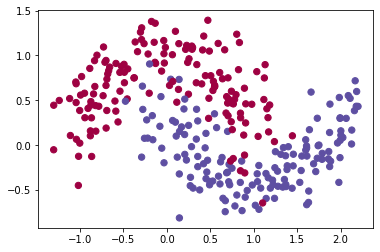

In [189]:
X_train, Y_train = load_dataset()

In [190]:
def L_Layer_model(X,Y, layers_dims, batch_size, learning_rate, epochs , print_cost,optimizer,beta1 = 0.9,beta2=0.999,epsilon=1e-8):
  costs = []
  seed = 10
  parameters = initialize_inner_parameters(layers_dim=layers_dims)
  m = Y.shape[1]
  t = 0
  if(optimizer=='grad'):
    pass
  elif(optimizer=='momentum'):
    print("Check init")
    v = initialize_velocity(parameters)
  elif(optimizer == 'adam'):
    v,s = initialize_parameters_adam(parameters)
  for i in range(epochs):
    seed = seed + 1
    mini_batches = random_mini_batches(X,Y,batch_size,seed)
    cost_total = 0
    for mini_batch in mini_batches:
      (minibatch_X, minibatch_Y) = mini_batch
      AL, caches = foward_prop_Llayers(minibatch_X, parameters)
      cost_total = cost_total + compute_cost(AL, minibatch_Y)
      grads = backward_prop_Llayer(AL, minibatch_Y, caches)

      if(optimizer=='grad'):
        parameters = update_parameters(parameters, grads,learning_rate)

      elif(optimizer=='momentum'):
        parameters,v = update_params_with_momentum(v,grads,parameters,beta1,learning_rate)
      
      elif(optimizer=='adam'):
        t = t+1
        parameters,v,s = update_parameters_with_adam(v,s,parameters,grads,learning_rate,beta1,beta2,t,epsilon)

    cost_avg = cost_total/m
    if print_cost and i % 1000 == 0 or i == epochs - 1:
      print("Cost after iteration {}: {}".format(i, cost_avg))
    if i % 100 == 0 or i == epochs:
      costs.append(cost_avg)
  
  plt.plot(costs)
  plt.xlabel("Number of epochs")
  plt.ylabel("Cost")
  plt.title("cOST VARIATION IN {}".format(optimizer))
  plt.show()
  return parameters

In [191]:
layers_dims = [X_train.shape[0],5,2,1]

Cost after iteration 0: 0.7091812056067225
Cost after iteration 1000: 0.6754480132621711
Cost after iteration 2000: 0.6160810261662746
Cost after iteration 3000: 0.5165580531251396
Cost after iteration 4000: 0.4482178299549734
Cost after iteration 4999: 0.40823409125646914


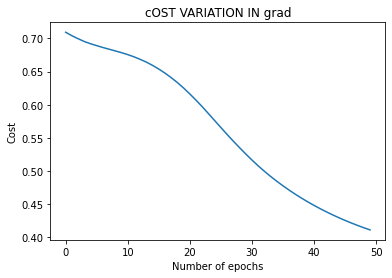

<class 'dict'>
Accuracy: 0.85


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


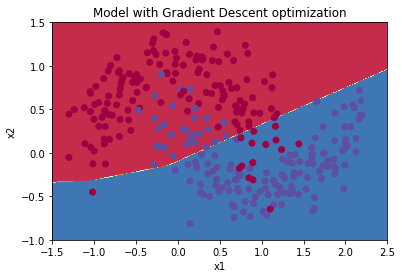

In [206]:
parameters = L_Layer_model(X_train, Y_train, layers_dims, batch_size=64, learning_rate=0.0007, epochs=5000,print_cost=True,optimizer='grad')
print(type(parameters))
Y_pred = predict(X_train, Y_train, parameters)
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)

#Mini-batch gradient descent with momentum

Initialize velocity

In [193]:
def initialize_velocity(parameters):
  L = len(parameters)//2
  V = {}
  for i in range(1,L+1):
    V["dW"+str(i)] = np.zeros(parameters["W"+str(i)].shape)
    V["db"+str(i)] = np.zeros(parameters["b"+str(i)].shape)
  return V

Update parameters with momentum

In [194]:
def update_params_with_momentum(V, grads,parameters,beta,learning_rate):
  L = len(parameters)//2
  for i in range(1,L+1):
    V["dW"+str(i)] = beta* V["dW"+str(i)] + ((1-beta)*(grads["dW"+str(i)]))
    V["db"+str(i)] = beta* V["db"+str(i)] + ((1-beta)*(grads["db"+str(i)]))
    parameters["W"+str(i)] = parameters["W"+str(i)] - (learning_rate*V["dW"+str(i)])
    parameters["b"+str(i)] = parameters["b"+str(i)] - (learning_rate*V["db"+str(i)])
  return parameters,V

Check init
Cost after iteration 0: 0.7091961296396988
Cost after iteration 1000: 0.6755283724412456
Cost after iteration 2000: 0.6164590158751249
Cost after iteration 3000: 0.5169548625974272
Cost after iteration 4000: 0.4484309499581464
Cost after iteration 4999: 0.40835333330273876


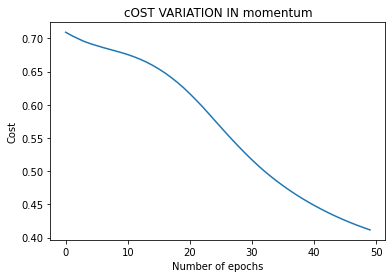

<class 'dict'>
Accuracy: 0.85


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


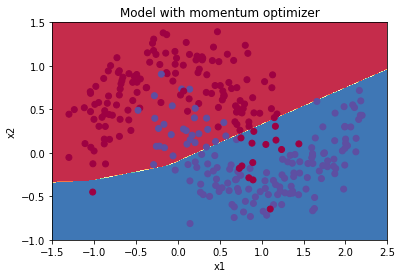

In [205]:
parameters = L_Layer_model(X_train, Y_train, layers_dims, batch_size=64, learning_rate=0.0007, 
                           epochs=5000,print_cost=True,optimizer='momentum')
print(type(parameters))
Y_pred = predict(X_train, Y_train, parameters)
plt.title("Model with momentum optimizer")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)

#Mini-batch gradient descent with Adam optimization

Initializing

In [203]:
def initialize_parameters_adam(parameters):
  L = len(parameters)//2
  V = {}
  S = {}
  for i in range(1,L+1):
    V["dW"+str(i)] = np.zeros(parameters["W"+str(i)].shape)
    V["db"+str(i)] = np.zeros(parameters["b"+str(i)].shape)
    S["dW"+str(i)] = np.zeros(parameters["W"+str(i)].shape)
    S["db"+str(i)] = np.zeros(parameters["b"+str(i)].shape)
  
  return V,S

Update parameters

In [197]:
from numpy.core.numerictypes import ScalarType
def update_parameters_with_adam(V,S,parameters, grads, learning_rate, beta1, beta2, t, epsilon):
  L = len(parameters)//2
  V_corrected = {}
  S_corrected = {}
  for i in range(1,L+1):
    V["dW"+str(i)] = beta1* V["dW"+str(i)] + ((1-beta1)*(grads["dW"+str(i)]))
    V["db"+str(i)] = beta1* V["db"+str(i)] + ((1-beta1)*(grads["db"+str(i)]))
    V_corrected["dW"+str(i)] =  V["dW"+str(i)] / (1-(beta1**t))
    V_corrected["db"+str(i)] =  V["db"+str(i)] / (1-(beta1**t))

    S["dW"+str(i)] = beta2* S["dW"+str(i)] + ((1-beta2)*((grads["dW"+str(i)])**2))
    S["db"+str(i)] = beta2* S["db"+str(i)] + ((1-beta2)*((grads["db"+str(i)])**2))
    S_corrected["dW"+str(i)] =  S["dW"+str(i)] / (1-(beta2**t))
    S_corrected["db"+str(i)] =  S["db"+str(i)] / (1-(beta2**t))

    parameters["W" + str(i)] = parameters["W" + str(i)] - ((learning_rate*V_corrected["dW" + str(i)])/(np.sqrt(S_corrected["dW" + str(i)])+epsilon))
    parameters["b" + str(i)] = parameters["b" + str(i)] - ((learning_rate*V_corrected["db" + str(i)])/(np.sqrt(S_corrected["db" + str(i)])+epsilon))

  return parameters,V,S

Cost after iteration 0: 0.7478976736490831
Cost after iteration 1000: 0.16476870083386458
Cost after iteration 2000: 0.13242204890103204
Cost after iteration 3000: 0.1302210277626886
Cost after iteration 4000: 0.1293481138420506
Cost after iteration 4999: 0.12846801215606474


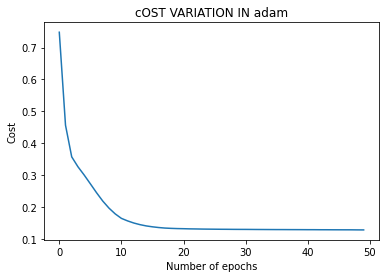

<class 'dict'>
Accuracy: 0.9433333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


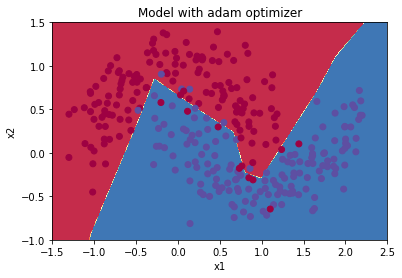

In [204]:
parameters = L_Layer_model(X_train, Y_train, layers_dims, batch_size=64, learning_rate=0.0007, 
                           epochs=5000,print_cost=True,optimizer='adam')
print(type(parameters))
Y_pred = predict(X_train, Y_train, parameters)
plt.title("Model with adam optimizer")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), X_train, Y_train)